In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
pip install filterpy

In [3]:
df = pd.read_csv("/content/time_series_data_human_activities.csv")

# cheking five fisrt samples
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


### Data Exploration

In [4]:
len(df)

1073623

In [5]:
df.shape

(1073623, 6)

In [6]:
df.columns

Index(['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'], dtype='object')

In [7]:
df.describe()

,user,timestamp,x-axis,y-axis,z-axis
count,1.073623e+06,1.073623e+06,1.073623e+06,1.073623e+06,1.073623e+06
mean,1.880682e+01,3.289157e+13,6.720567e-01,7.332700e+00,4.024567e-01
std,1.028704e+01,4.909825e+13,6.916894e+00,6.732950e+00,4.789301e+00
min,1.000000e+00,7.345234e+10,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.057092e+12,-2.960000e+00,3.340000e+00,-2.260978e+00
50%,1.900000e+01,9.750603e+12,3.400000e-01,8.010000e+00,-4.000000e-02
75%,2.800000e+01,3.525530e+13,4.520000e+00,1.160000e+01,2.760000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [8]:
# Determining the number of users
unique_users = df['user'].unique()
print(f"Number of unique users: {unique_users}")

Number of unique users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


In [9]:
unique_activities = df['activity'].unique()
print(unique_activities)

['Walking' 'Jogging' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073623 entries, 0 to 1073622
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1073623 non-null  int64  
 1   activity   1073623 non-null  object 
 2   timestamp  1073623 non-null  int64  
 3   x-axis     1073623 non-null  float64
 4   y-axis     1073623 non-null  float64
 5   z-axis     1073623 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 49.1+ MB


In [11]:
df.isnull().sum()

,0
user,0
activity,0
timestamp,0
x-axis,0
y-axis,0
z-axis,0


 ### Percentage of Activities

<ipython-input-12-7c33727463bf>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='activity',


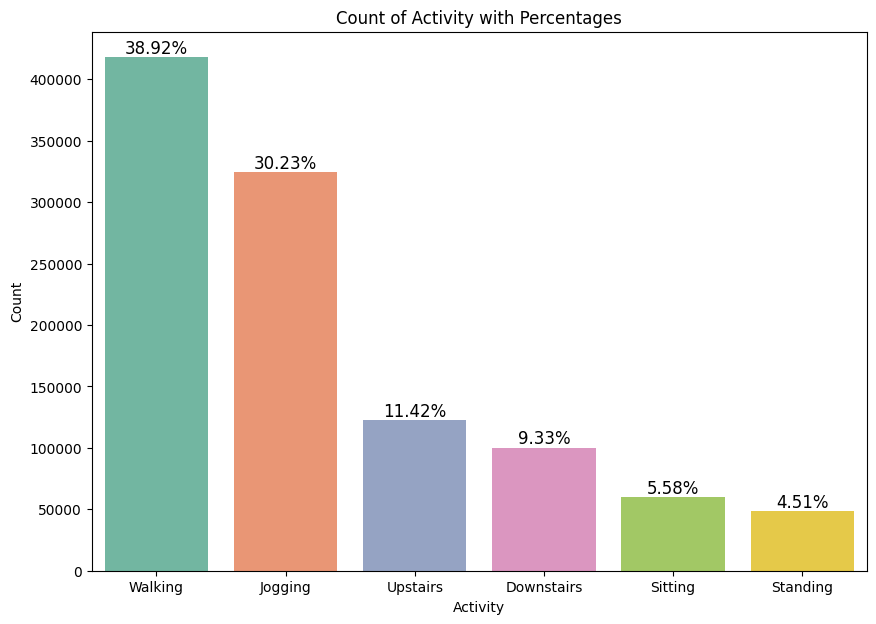

In [12]:
# Calculate the percentage of each activity
activity_counts = df['activity'].value_counts()
total = len(df)
activity_percentages = (activity_counts / total) * 100

# Plot the count plot
plt.figure(figsize=(10, 7))
sns.countplot(x='activity',
              data=df,
              order=df.activity.value_counts().index,
              palette="Set2")

# Add percentage labels on top of each bar
for i, count in enumerate(activity_counts):
    percentage = f'{(count / total) * 100:.2f}%'  # Format the percentage
    plt.text(i, count + 10, percentage, ha='center', va='bottom', fontsize=12, color='black')

# Add title and labels
plt.title("Count of Activity with Percentages")
plt.xlabel("Activity")
plt.ylabel("Count")

plt.show()


In [13]:
# Check the distribution of the activities
Count_Activity = df['activity'].value_counts()
print(Count_Activity)

activity
Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: count, dtype: int64


we can see that our data is imbalanced. So, first we have to balance it

### `create_model_checkpoint` Function

The create_model_checkpoint function sets up an **EarlyStopping** callback to be used during the training of a machine learning model, particularly in deep learning tasks. This callback helps to prevent overfitting by monitoring a specified metric (such as validation loss) during training and halting the process if the metric stops improving for a certain number of epochs.

**Why Use It:**
- **Prevent Overfitting**: Stops training before the model starts to overfit, ensuring better generalization to unseen data.
- **Save Resources**: Avoids unnecessary training epochs, saving time and computational resources.
- **Automatic Stopping**: No need to manually monitor training progress, as the callback automatically stops training at the optimal point.



In [14]:

def create_model_checkpoint(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    checkpoint_filepath='best_model.h5.keras',
    save_best_only=True,
    mode='min'
):
    """
    Creates EarlyStopping and ModelCheckpoint callbacks to be used during model training.

    Parameters:
    - monitor (str): The metric to monitor. Defaults to 'val_loss'.
    - patience (int): Number of epochs with no improvement after which training will be stopped. Defaults to 3.
    - restore_best_weights (bool): Whether to restore model weights from the epoch with the best monitored value. Defaults to True.
    - checkpoint_filepath (str): Filepath to save the best model. Defaults to 'best_model.h5'.
    - save_best_only (bool): Whether to save only the best model. Defaults to True.
    - mode (str): One of {'min', 'max'}. In 'min' mode, training will stop when the quantity monitored has stopped decreasing; in 'max' mode, it will stop when the quantity monitored has stopped increasing. Defaults to 'min'.

    Returns:
    - callbacks (list): A list containing the configured EarlyStopping and ModelCheckpoint callbacks.
    """

    # EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=restore_best_weights,
        mode=mode
    )

    # ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        mode=mode
    )

    # Return both callbacks in a list
    return [early_stopping, model_checkpoint]


### Kalman Filter

In [ ]:
from filterpy.kalman import KalmanFilter
import pandas as pd

# Function to apply Kalman filter to 1D data
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)  # A basic 1D Kalman filter
    kf.x = np.array([0., 0.])  # Initial state [position, velocity]
    kf.F = np.array([[1., 1.], [0., 1.]])  # State transition matrix
    kf.H = np.array([[1., 0.]])  # Measurement function
    kf.P *= 1000.  # Covariance matrix
    kf.R = 5  # Measurement uncertainty
    kf.Q = np.eye(2) * 0.1  # Process uncertainty

    smoothed_data = []
    for z in data:
        kf.predict()
        kf.update([z])
        smoothed_data.append(kf.x[0])  # Append the position (the first state variable)

    return np.array(smoothed_data)

# Apply Kalman filter to each axis (x, y, z)
df['x-axis_kalman'] = apply_kalman_filter(df['x-axis'].values)
df['y-axis_kalman'] = apply_kalman_filter(df['y-axis'].values)
df['z-axis_kalman'] = apply_kalman_filter(df['z-axis'].values)

# Extract the Kalman-filtered features
features_kalman = df[['x-axis_kalman', 'y-axis_kalman', 'z-axis_kalman']].values
labels = df['activity'].values  # activity labels



### Sliding Window Segmentation

This transformation will help capture the temporal patterns essential for activity recognition and will make your data suitable for use in models like LSTMs, CNNs, or even traditional machine learning models that benefit from sequential context.

In [15]:
import numpy as np

# Parameters
window_size = 400  # Assuming data collected at 20Hz, 400 data points = 20 seconds
step_size = 200    # 50% overlap

# Function to segment the data using a sliding window
def create_sliding_windows(data, labels, window_size, step_size):
    windows = []
    window_labels = []

    for i in range(0, len(data) - window_size, step_size):
        window = data[i:i + window_size]
        windows.append(window)
        window_labels.append(labels[i + window_size - 1])  # label for the window based on last point

    return np.array(windows), np.array(window_labels)


# Extract the features (x, y, z) and labels
features = df[['x-axis', 'y-axis', 'z-axis']].values
labels = df['activity'].values

# Create sliding windows
X_windows, y_windows = create_sliding_windows(features, labels, window_size, step_size)

# Check the shape of the resulting data
print(f"Shape of X_windows: {X_windows.shape}")  # Should be (num_samples, window_size, num_features)
print(f"Shape of y_windows: {y_windows.shape}")  # Should be (num_samples,)


Shape of X_windows: (5367, 400, 3)
Shape of y_windows: (5367,)


### Feature Extraction from Windows

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft

# Feature engineering function to extract statistical and frequency domain features from a window
def extract_features_from_window(window):
    features = []

    # Separate the window into x, y, z components
    x_data = window[:, 0]
    y_data = window[:, 1]
    z_data = window[:, 2]

    for data in [x_data, y_data, z_data]:
        # Statistical Features
        mean = np.mean(data)
        std_dev = np.std(data)
        variance = np.var(data)
        max_val = np.max(data)
        min_val = np.min(data)
        range_val = max_val - min_val
        median = np.median(data)
        skewness = skew(data)
        kurt = kurtosis(data)

        # Frequency Domain Features: FFT
        fft_vals = np.abs(fft(data))
        fft_mean = np.mean(fft_vals)
        fft_std = np.std(fft_vals)
        fft_max = np.max(fft_vals)
        fft_min = np.min(fft_vals)

        # Combine all features for the current axis
        features.extend([mean, std_dev, variance, max_val, min_val, range_val, median, skewness, kurt,
                         fft_mean, fft_std, fft_max, fft_min])

    return features

# Apply feature extraction to each window
def extract_features_from_windows(X_windows):
    feature_list = []
    for window in X_windows:
        features = extract_features_from_window(window)
        feature_list.append(features)

    return np.array(feature_list)

# Extract features from the Kalman-filtered windows
X_features_kalman = extract_features_from_windows(X_windows_kalman)

# Check the shape of the resulting feature data
print(f"Shape of X_features_kalman: {X_features_kalman.shape}")  # Expected (num_windows, num_features)


Shape of X_features_kalman: (5367, 39)


### Splitting Data into Train and Test set

In [ ]:
# For RandomForestClassifier: Use the 2D feature matrix
X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_features_kalman, y_windows_kalman, test_size=0.3, stratify=y_windows_kalman, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, stratify=y_temp_rf, random_state=42)

# Check the shapes of the resulting datasets
print(f"RandomForest - Training set: {X_train_rf.shape}, {y_train_rf.shape}")
print(f"RandomForest - Validation set: {X_val_rf.shape}, {y_val_rf.shape}")
print(f"RandomForest - Test set: {X_test_rf.shape}, {y_test_rf.shape}")


RandomForest - Training set: (3756, 39), (3756,)
RandomForest - Validation set: (805, 39), (805,)
RandomForest - Test set: (806, 39), (806,)


In [16]:
from sklearn.model_selection import train_test_split
# For LSTM: Using the 3D sliding windows


# First split into train and temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, stratify=y_windows, random_state=42)

# Further split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check the shapes of the resulting datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (3756, 400, 3), (3756,)
Validation set: (805, 400, 3), (805,)
Test set: (806, 400, 3), (806,)


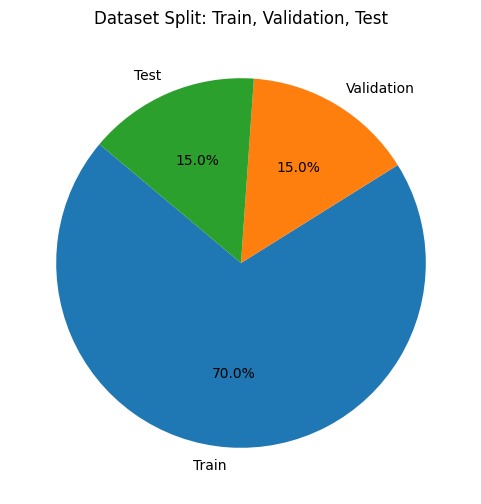

In [17]:
import matplotlib.pyplot as plt

train_size = 0.7  # 70% of the data
val_size = 0.15  # 15% of the data
test_size = 0.15  # 15% of the data

# Labels and sizes for the pie chart
labels = ['Train', 'Validation', 'Test']
sizes = [train_size, val_size, test_size]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plotting the pie chart
plt.figure(figsize=(14,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Dataset Split: Train, Validation, Test')
plt.show()


### Balance Data. SMOTE technique

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the 2D reshaped data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_rf, y_train_rf)

# Check the new shape of the balanced training data
print(f"Balanced Training set: {X_train_balanced.shape}, {y_train_balanced.shape}")

Balanced Training set: (8772, 39), (8772,)


### Baseline model. RandomForestClassifier

Since here we have 3D data we need to reshape it to 2D and then feed it into the Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Train the RandomForestClassifier using class weights to handle imbalance
rf_model_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model directly on the 2D training data
rf_model_weighted.fit(X_train_rf, y_train_rf)

# Predict on validation data
y_val_pred_weighted = rf_model_weighted.predict(X_val_rf)

# Predict on test data
y_test_pred_weighted = rf_model_weighted.predict(X_test_rf)

# Generate and print the classification report for validation data
print("Validation Data Classification Report:")
print(classification_report(y_val_rf, y_val_pred_weighted, target_names=np.unique(y_train_rf).astype(str)))

# Generate and print the classification report for test data
print("Test Data Classification Report:")
print(classification_report(y_test_rf, y_test_pred_weighted, target_names=np.unique(y_train_rf).astype(str)))

# Generate and print the confusion matrix for validation data
print("Validation Data Confusion Matrix:")
print(confusion_matrix(y_val_rf, y_val_pred_weighted))

# Generate and print the confusion matrix for test data
print("Test Data Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_test_pred_weighted))


Validation Data Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.74      0.52      0.61        75
     Jogging       0.91      0.97      0.94       244
     Sitting       0.98      0.89      0.93        45
    Standing       0.89      0.94      0.92        36
    Upstairs       0.70      0.66      0.68        92
     Walking       0.92      0.96      0.94       313

    accuracy                           0.88       805
   macro avg       0.86      0.82      0.84       805
weighted avg       0.88      0.88      0.88       805

Test Data Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.77      0.68      0.72        75
     Jogging       0.91      0.97      0.94       244
     Sitting       0.96      0.96      0.96        45
    Standing       0.97      0.86      0.91        36
    Upstairs       0.85      0.70      0.77        92
     Walking       0.92      0.96      0.94       314

    a

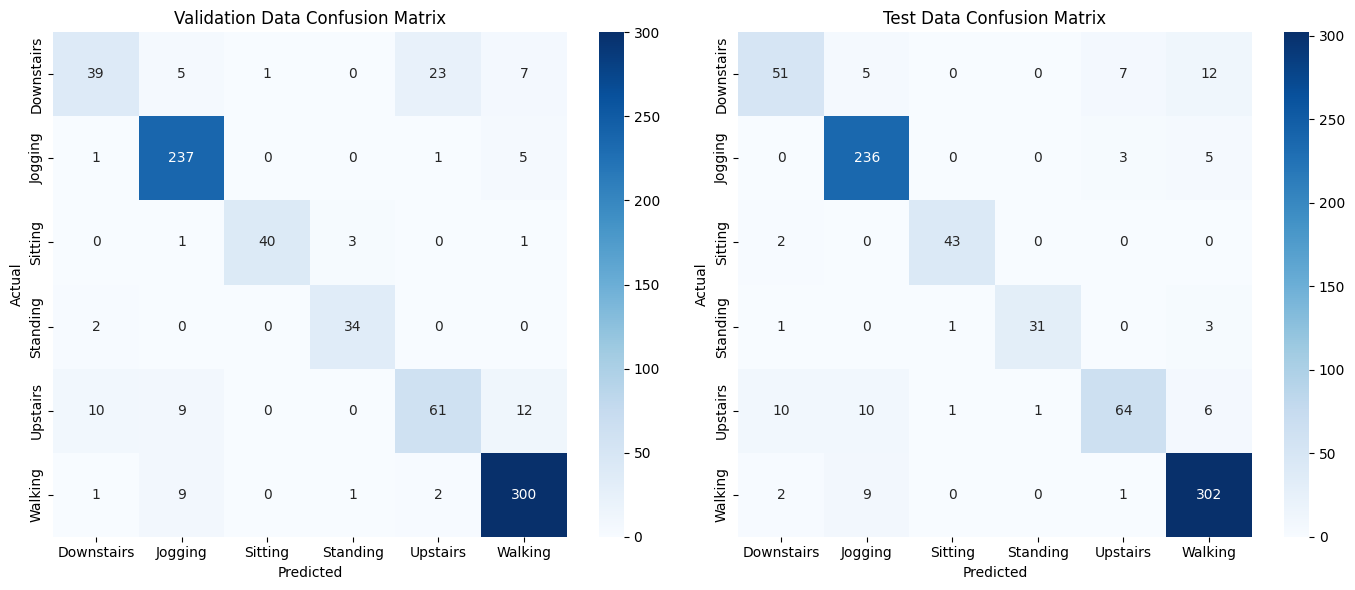

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrices
conf_matrix_val = confusion_matrix(y_val_rf, y_val_pred_weighted)
conf_matrix_test = confusion_matrix(y_test_rf, y_test_pred_weighted)

# Activity labels
labels = np.unique(y_train_rf)

# Plotting the confusion matrix for Validation Data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Validation Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plotting the confusion matrix for Test Data
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Test Data Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Shape of y_train_balanced: {y_train_balanced.shape}")
print(f"Shape of X_train_balanced: {X_train_balanced.shape}")

Shape of y_train_balanced: (8772,)
Shape of X_train_balanced: (8772, 39)


In [ ]:
y_train_balanced.shape

(8772,)

### One-Hot Encoder

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Reshape y_train to a 2D array with a single column
y_train = y_train.reshape(-1, 1)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)

# Reshape y_test to a 2D array with a single column
y_test = y_test.reshape(-1, 1)
y_test = enc.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
y_train.shape, X_train.shape

((3756, 6), (3756, 400, 3))

In [21]:
X_test.shape, y_test.shape

((806, 400, 3), (806, 6))

### Model 1. LSTM + DENSE

In [23]:
%%time
model_1 = keras.Sequential(name="model_1_LSTM_DENSE")
model_1.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model_1.add(keras.layers.Dropout(rate=0.5))
model_1.add(keras.layers.Dense(units=128, activation='relu'))
model_1.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

# Create early stopping callback
early_stopping_callback = create_model_checkpoint(monitor='val_loss', patience=3)

history = model_1.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping_callback] # Include the early stopping callback
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - acc: 0.4418 - loss: 1.4705 - val_acc: 0.6995 - val_loss: 0.9242
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - acc: 0.7048 - loss: 0.9009 - val_acc: 0.6995 - val_loss: 0.8317
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - acc: 0.7342 - loss: 0.7758 - val_acc: 0.7606 - val_loss: 0.6681
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - acc: 0.7539 - loss: 0.6982 - val_acc: 0.7580 - val_loss: 0.6695
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.7465 - loss: 0.6664 - val_acc: 0.7846 - val_loss: 0.5562
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - acc: 0.8011 - loss: 0.5676 - val_acc: 0.7660 - val_loss: 0.6005
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - acc: 0.7999 - loss: 0.5596 - val_acc: 0.7846 - val_loss: 0.5618
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.8054 - loss: 0.5267 - val_acc: 0.7979 - val_loss: 0.4987
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - acc: 0.8169 - loss: 

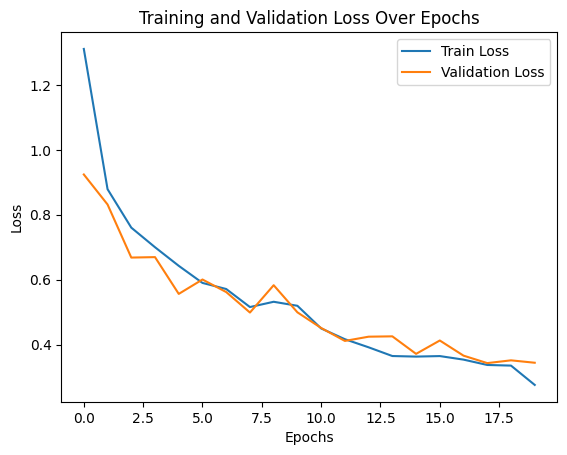

In [24]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [25]:
model_1.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 492ms/step - acc: 0.8384 - loss: 0.3990


[0.3791426420211792, 0.844913125038147]

In [26]:
y_pred_model_1 = model_1.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step


In [27]:
# list of activity names
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Evaluate the model using y_test directly
y_pred_classes = np.argmax(y_pred_model_1, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report with activity names
report = classification_report(y_test_classes, y_pred_classes, target_names=activity_names)

print(f"model_1_LSTM_DENSE Accuracy: {accuracy}")
print("Classification Report:\n", report)

model_1_LSTM_DENSE Accuracy: 0.8449131513647643
Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.48      0.40      0.43        75
     Jogging       0.97      0.99      0.98       244
     Sitting       1.00      0.91      0.95        45
    Standing       0.71      0.89      0.79        36
    Upstairs       0.54      0.45      0.49        92
     Walking       0.89      0.94      0.91       314

    accuracy                           0.84       806
   macro avg       0.76      0.76      0.76       806
weighted avg       0.83      0.84      0.84       806



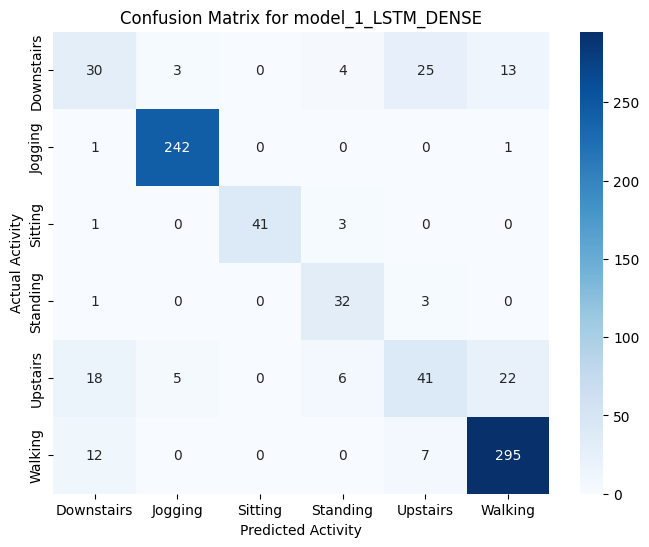

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_classes and y_pred_classes are already defined and contain the actual and predicted class indices

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Activity names corresponding to class indices
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.title("Confusion Matrix for model_1_LSTM_DENSE")
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.show()


### Model 2. LSTM without L2 Reqularization

In [29]:
%%time
model_2 = keras.Sequential(name="model_2_LSTM_without_L2")
model_2.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]],
          # To ensure that the next LSTM layer receives a 3D input, we set return_sequences=True
          return_sequences=True
      )
    )
)
model_2.add(keras.layers.Dropout(rate=0.5))

# Final LSTM layer to produce the classification output directly
model_2.add(keras.layers.LSTM(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

# Create early stopping callback
early_stopping_callback = create_model_checkpoint(monitor='val_loss', patience=3)

# Train the model
history = model_2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping_callback]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - acc: 0.4450 - loss: 1.5121 - val_acc: 0.7128 - val_loss: 0.8722
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - acc: 0.7163 - loss: 0.8544 - val_acc: 0.7314 - val_loss: 0.7091
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.7304 - loss: 0.7531 - val_acc: 0.7686 - val_loss: 0.6219
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - acc: 0.7924 - loss: 0.5878 - val_acc: 0.7367 - val_loss: 0.6265
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - acc: 0.7813 - loss: 0.5959 - val_acc: 0.8005 - val_loss: 0.5212
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - acc: 0.8336 - loss: 0.4654 - val_acc: 0.8165 - val_loss: 0.4477
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - acc: 0.8485 - loss: 0.4061 - val_acc: 0.8271 - val_loss: 0.4149
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - acc: 0.8454 - loss: 0.3709 - val_acc: 0.8005 - val_loss: 0.4403
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - acc: 0.8543 - loss: 0.3939 - va

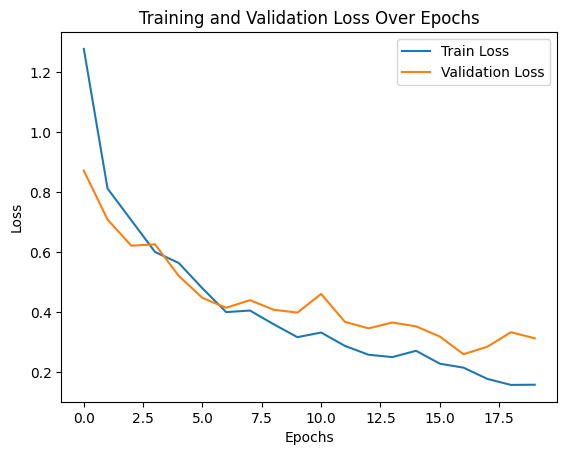

In [30]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [31]:
model_2.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - acc: 0.9073 - loss: 0.3087


[0.2813364565372467, 0.9143920540809631]

In [32]:
y_pred_model_2 = model_2.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step


In [33]:
# list of activity names
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Evaluate the model using y_test directly
y_pred_classes = np.argmax(y_pred_model_2, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report with activity names
report = classification_report(y_test_classes, y_pred_classes, target_names=activity_names)

print(f"model_2_LSTM_without_L2 Accuracy: {accuracy}")
print("Classification Report:\n", report)


model_2_LSTM_without_L2 Accuracy: 0.9143920595533499
Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.90      0.57      0.70        75
     Jogging       0.99      0.98      0.98       244
     Sitting       1.00      0.91      0.95        45
    Standing       0.92      0.94      0.93        36
    Upstairs       0.71      0.78      0.75        92
     Walking       0.91      0.98      0.95       314

    accuracy                           0.91       806
   macro avg       0.90      0.86      0.88       806
weighted avg       0.92      0.91      0.91       806



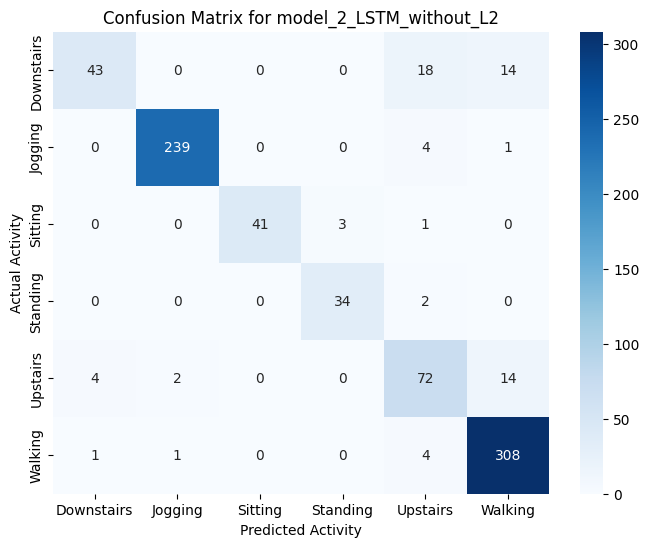

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_classes and y_pred_classes are already defined and contain the actual and predicted class indices

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Activity names corresponding to class indices
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.title("Confusion Matrix for model_2_LSTM_without_L2")
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.show()


### Model 3. LSTM with L2 Regularization

In [35]:
%%time
model_3 = keras.Sequential(name="model_3_LSTM_L2_Regularization")
model_3.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]],
          kernel_regularizer=regularizers.l2(0.01),  # Adding L2 regularization
          # To ensure that the next LSTM layer receives a 3D input, we set return_sequences=True
          return_sequences=True
      )
    )
)
model_3.add(keras.layers.Dropout(rate=0.5))

# Final LSTM layer to produce the classification output directly
model_3.add(keras.layers.LSTM(units=y_train.shape[1],
                              activation='softmax',
                              kernel_regularizer=regularizers.l2(0.01)))  # Adding L2 regularization

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

# Create early stopping callback
early_stopping_callback = create_model_checkpoint(monitor='val_loss', patience=3)

# Train the model
history = model_3.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping_callback]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - acc: 0.4626 - loss: 2.0315 - val_acc: 0.6729 - val_loss: 1.4115
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - acc: 0.7076 - loss: 1.3118 - val_acc: 0.7234 - val_loss: 1.1053
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - acc: 0.7685 - loss: 1.0368 - val_acc: 0.7872 - val_loss: 0.9224
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - acc: 0.8001 - loss: 0.8685 - val_acc: 0.8085 - val_loss: 0.7853
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - acc: 0.8223 - loss: 0.7697 - val_acc: 0.8112 - val_loss: 0.7598
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - acc: 0.8239 - loss: 0.7277 - val_acc: 0.7899 - val_loss: 0.7219
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.8335 - loss: 0.6626 - val_acc: 0.8298 - val_loss: 0.6616
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - acc: 0.8478 - loss: 0.6259 - val_acc: 0.8537 - val_loss: 0.6000
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.8643 - loss:

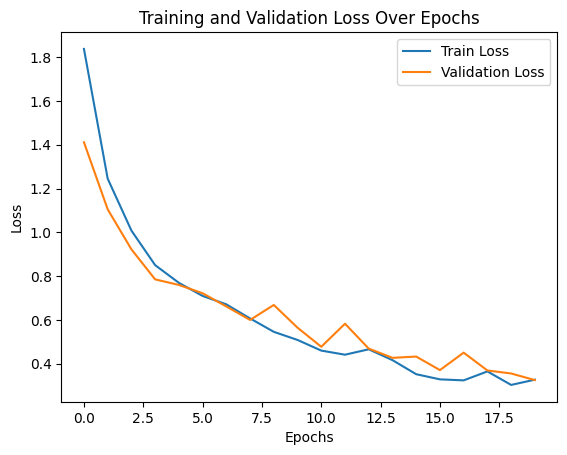

In [36]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [37]:
model_3.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - acc: 0.9208 - loss: 0.3472


[0.31252017617225647, 0.9330024719238281]

In [38]:
y_pred_model_3 = model_3.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step


In [39]:
# list of activity names
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Evaluate the model using y_test directly
y_pred_classes = np.argmax(y_pred_model_3, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report with activity names
report = classification_report(y_test_classes, y_pred_classes, target_names=activity_names)

print(f"model_3_LSTM_L2_Regularization Accuracy: {accuracy}")
print("Classification Report:\n", report)


model_3_LSTM_L2_Regularization Accuracy: 0.9330024813895782
Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.75      0.80      0.77        75
     Jogging       0.99      0.99      0.99       244
     Sitting       1.00      0.89      0.94        45
    Standing       0.90      1.00      0.95        36
    Upstairs       0.81      0.84      0.82        92
     Walking       0.97      0.95      0.96       314

    accuracy                           0.93       806
   macro avg       0.90      0.91      0.91       806
weighted avg       0.94      0.93      0.93       806



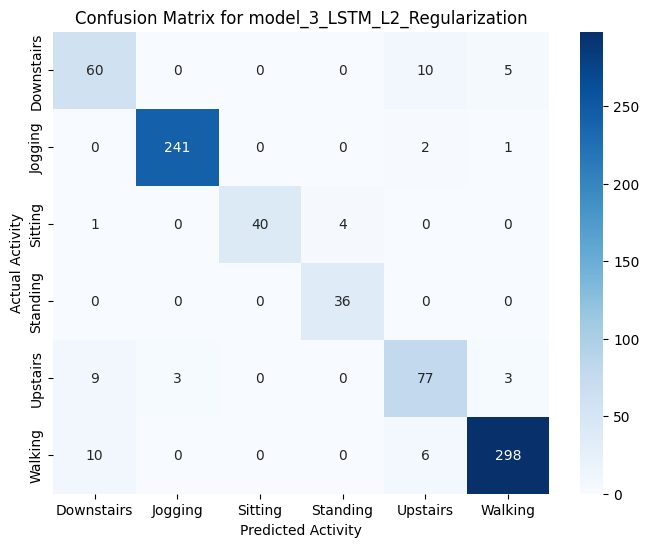

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_classes and y_pred_classes are already defined and contain the actual and predicted class indices

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Activity names corresponding to class indices
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.title("Confusion Matrix for model_3_LSTM_L2_Regularization")
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.show()


### Model 4. CNN-LSTM Hybrid Model

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    # Create a sequential model
    model_4 = keras.Sequential(name="model_4_CNN_LSTM")

    # 1. CNN Layers: Tune filters and kernel size
    model_4.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=256, step=32),  # Tune filters
        kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),  # Tune kernel size
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model_4.add(layers.MaxPooling1D(pool_size=2))

    # 2. LSTM Layer: Tune units
    model_4.add(layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False
    ))

    # 3. Dropout Layer: Tune dropout rate
    model_4.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))

    # 4. Dense Layer: Tune units
    model_4.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))

    # 5. Output layer
    model_4.add(layers.Dense(units=y_train.shape[1], activation='softmax'))

    # Compile the model
    model_4.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )

    return model_4


ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
# Set up the tuner
tuner = kt.RandomSearch(
    build_model,  # The model-building function
    objective='val_loss',  # The objective to minimize
    max_trials=10,  # Number of different hyperparameter sets to try
    executions_per_trial=1,  # Number of times to train the model for each trial
    directory='tuner_results',  # Directory to save the results
    project_name='cnn_lstm_tuning'  # Name for this tuning project
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[early_stopping_callback],
             batch_size=128)


Trial 10 Complete [00h 01m 39s]
val_loss: 0.5965321063995361

Best val_loss So Far: 0.48032262921333313
Total elapsed time: 00h 18m 54s


In [ ]:
# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_hp.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Train the best model if needed
history = best_model.fit(X_train, y_train,
                         epochs=20,
                         batch_size=128,
                         validation_split=0.1,
                         callbacks=[early_stopping_callback])


Best hyperparameters: {'filters': 96, 'kernel_size': 5, 'lstm_units': 192, 'dropout_rate': 0.4, 'dense_units': 64}
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - acc: 0.4913 - loss: 1.3235 - val_acc: 0.7793 - val_loss: 0.6300
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - acc: 0.7832 - loss: 0.6432 - val_acc: 0.8112 - val_loss: 0.5514
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - acc: 0.7969 - loss: 0.5655 - val_acc: 0.8112 - val_loss: 0.5344


In [41]:
%%time
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN-LSTM Hybrid Model
model_4 = keras.Sequential(name= "model_4_CNN_LSTM")

# 1. CNN Layers: To extract spatial features
model_4.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_4.add(layers.MaxPooling1D(pool_size=2))


# 2. LSTM Layer: To capture temporal dependencies
model_4.add(layers.LSTM(units=128, return_sequences=False))  # Set return_sequences=True if you plan to stack LSTM layers

# 3. Dropout Layer: To prevent overfitting
model_4.add(layers.Dropout(rate=0.5))

# 4. Dense Layer: For the final classification
model_4.add(layers.Dense(units=128, activation='relu'))
model_4.add(layers.Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

# Create early stopping callback
early_stopping_callback = create_model_checkpoint(monitor='val_loss', patience=3)

# Train the model
history = model_4.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping_callback]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 881ms/step - acc: 0.4167 - loss: 1.5062 - val_acc: 0.7048 - val_loss: 0.8384
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 820ms/step - acc: 0.7381 - loss: 0.7864 - val_acc: 0.7686 - val_loss: 0.6460
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 841ms/step - acc: 0.7688 - loss: 0.6784 - val_acc: 0.7181 - val_loss: 0.7720
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 949ms/step - acc: 0.7705 - loss: 0.6311 - val_acc: 0.8005 - val_loss: 0.5183
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 902ms/step - acc: 0.8061 - loss: 0.5385 - val_acc: 0.7952 - val_loss: 0.5302
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - acc: 0.8270 - loss: 0.4796 - val_acc: 0.7766 - val_loss: 0.4815
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 921ms/step - acc: 0.8408 - loss: 0.4436 - val_acc: 0.8138 - val_loss: 0.4317
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 834ms/step - acc: 0.8413 - loss: 0.4020 - val_acc: 0.8138 - val_loss: 0.4271
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 897ms/step - acc:

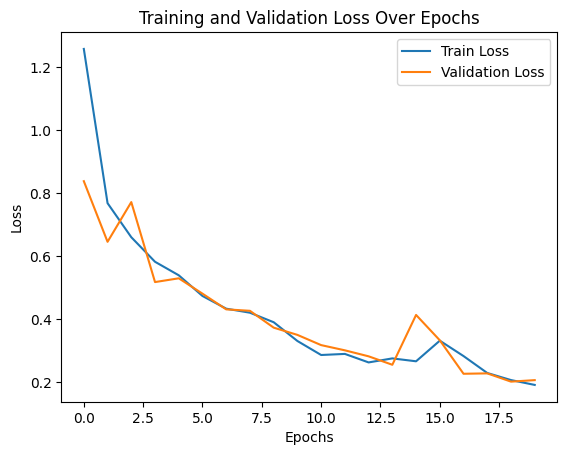

In [42]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [43]:
model_4.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - acc: 0.9091 - loss: 0.2952


[0.2660095989704132, 0.9168734550476074]

In [44]:
y_pred_model_4 = model_4.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


In [45]:
# list of activity names
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Evaluate the model using y_test directly
y_pred_classes = np.argmax(y_pred_model_4, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report with activity names
report = classification_report(y_test_classes, y_pred_classes, target_names=activity_names)

print(f"model_4_CNN_LSTM Accuracy: {accuracy}")
print("Classification Report:\n", report)


model_4_CNN_LSTM Accuracy: 0.9168734491315137
Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.66      0.64      0.65        75
     Jogging       1.00      1.00      1.00       244
     Sitting       0.98      0.91      0.94        45
    Standing       0.92      0.97      0.95        36
    Upstairs       0.77      0.72      0.74        92
     Walking       0.95      0.97      0.96       314

    accuracy                           0.92       806
   macro avg       0.88      0.87      0.87       806
weighted avg       0.91      0.92      0.92       806



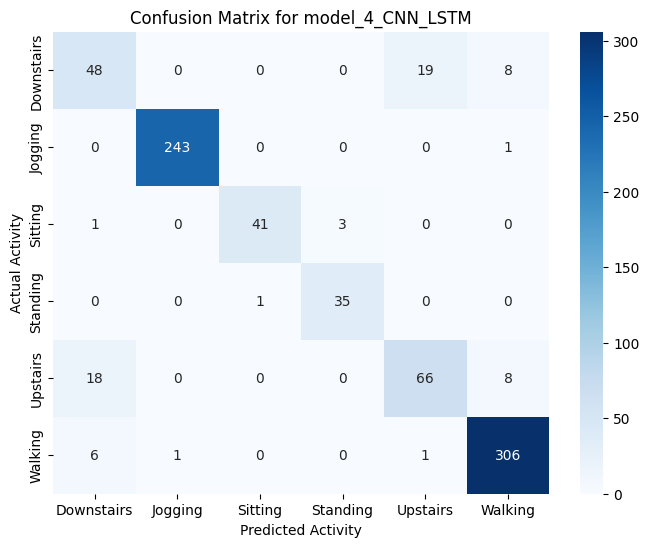

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_classes and y_pred_classes are already defined and contain the actual and predicted class indices

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Activity names corresponding to class indices
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.title("Confusion Matrix for model_4_CNN_LSTM")
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.show()


### Model 5. GRU-LSTM Hybrid Model

In [47]:
%%time
from os import name
from tensorflow import keras
from tensorflow.keras import layers

# Define the GRU-LSTM Hybrid Model
model_5 = keras.Sequential(name="model_5_GRU_LSTM")

# 1. GRU Layer: To capture temporal dependencies more efficiently
model_5.add(layers.GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# 2. LSTM Layer: To further capture long-term dependencies
model_5.add(layers.LSTM(units=128, return_sequences=False))  # return_sequences=False because we are not stacking another RNN layer

# 3. Dropout Layer: To prevent overfitting
model_5.add(layers.Dropout(rate=0.5))

# 4. Dense Layer: For the final classification
model_5.add(layers.Dense(units=128, activation='relu'))
model_5.add(layers.Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
model_5.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

# Create early stopping callback
early_stopping_callback = create_model_checkpoint(monitor='val_loss', patience=3)

# Train the model
history = model_5.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stopping_callback]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - acc: 0.5032 - loss: 1.3770 - val_acc: 0.7074 - val_loss: 0.7935
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - acc: 0.7262 - loss: 0.7975 - val_acc: 0.7287 - val_loss: 0.7120
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.7295 - loss: 0.7524 - val_acc: 0.7606 - val_loss: 0.6380
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.7662 - loss: 0.6502 - val_acc: 0.7793 - val_loss: 0.5778
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - acc: 0.7936 - loss: 0.5677 - val_acc: 0.7926 - val_loss: 0.5282
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.8026 - loss: 0.5524 - val_acc: 0.7261 - val_loss: 0.7195
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - acc: 0.7571 - loss: 0.6888 - val_acc: 0.7952 - val_loss: 0.5584
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - acc: 0.8065 - loss: 0.5500 - val_acc: 0.7979 - val_loss: 0.5146
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - acc: 0.8162 - loss: 0.4957 - va

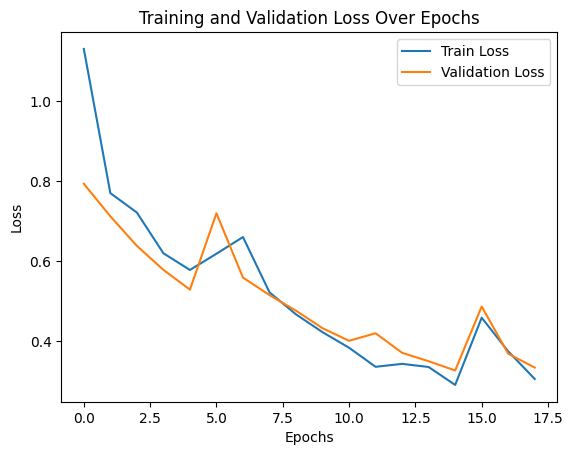

In [48]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()


In [49]:
model_5.evaluate(X_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - acc: 0.8775 - loss: 0.2915


[0.29845061898231506, 0.8821340203285217]

In [50]:
y_pred_model_5 = model_5.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step


In [51]:
# list of activity names
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Evaluate the model using y_test directly
y_pred_classes = np.argmax(y_pred_model_5, axis=1)  # Convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)

# Generate classification report with activity names
report = classification_report(y_test_classes, y_pred_classes, target_names=activity_names)

print(f"model_5_GRU_LSTM Accuracy: {accuracy}")
print("Classification Report:\n", report)


model_5_GRU_LSTM Accuracy: 0.8821339950372209
Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.60      0.53      0.56        75
     Jogging       0.98      0.99      0.99       244
     Sitting       1.00      0.91      0.95        45
    Standing       0.92      0.97      0.95        36
    Upstairs       0.60      0.57      0.58        92
     Walking       0.92      0.96      0.94       314

    accuracy                           0.88       806
   macro avg       0.84      0.82      0.83       806
weighted avg       0.88      0.88      0.88       806



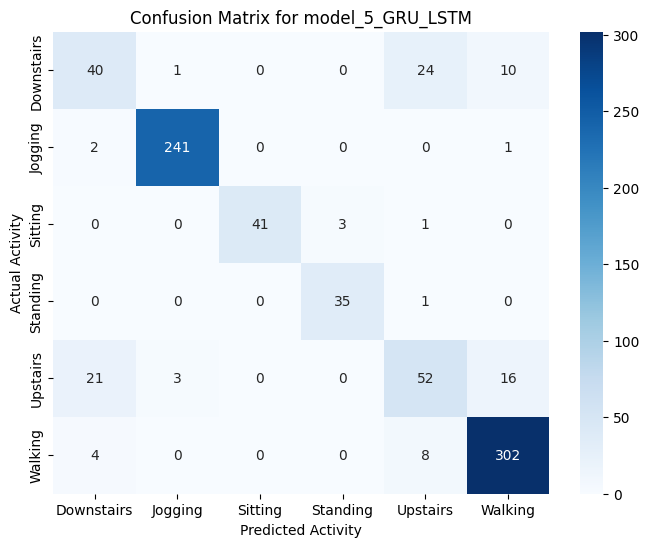

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_classes and y_pred_classes are already defined and contain the actual and predicted class indices

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Activity names corresponding to class indices
activity_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=activity_names, yticklabels=activity_names)
plt.title("Confusion Matrix for model_5_GRU_LSTM")
plt.xlabel("Predicted Activity")
plt.ylabel("Actual Activity")
plt.show()


### Models comparisions

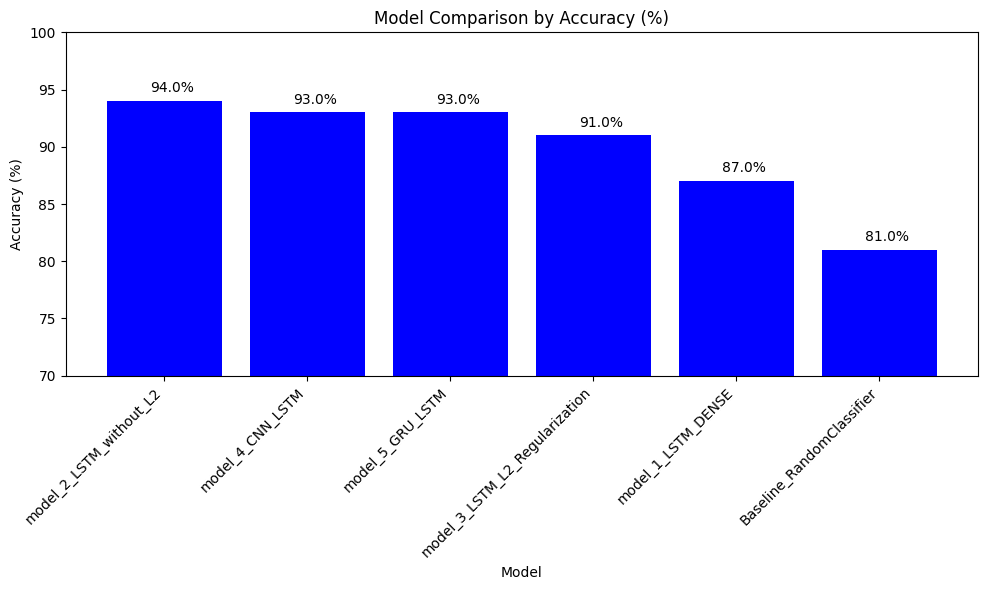

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample accuracies for the models
# Assuming these are accuracy values from the trained models
model_results = pd.DataFrame({
    "Model": ["Baseline_RandomClassifier", "model_1_LSTM_DENSE", "model_2_LSTM_without_L2",
              "model_3_LSTM_L2_Regularization", "model_4_CNN_LSTM", "model_5_GRU_LSTM"],
    "Accuracy (%)": [81, 87, 94, 91, 93, 93]
})

# Sort the results by accuracy for better visualization
model_results = model_results.sort_values(by="Accuracy (%)", ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_results["Model"], model_results["Accuracy (%)"], color='blue')

# Add percentages on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.5, f"{yval:.1f}%", va='bottom')

# Adding labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison by Accuracy (%)")
plt.xticks(rotation=45, ha='right')
plt.ylim(70, 100)  # Adjust the y-axis limit for better spacing

plt.tight_layout()
plt.show()
